In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import ta
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, accuracy_score,
    confusion_matrix, classification_report, PrecisionRecallDisplay, roc_curve, precision_recall_curve # <-- Убедитесь, что эта строка здесь
)
from sklearn.preprocessing import StandardScaler 
from imblearn.over_sampling import SMOTE 

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier # Для XGBoost
from sklearn.linear_model import LogisticRegression

In [2]:
ticker = 'BTC-USD'
start_date = '2022-07-10'
end_date = pd.to_datetime('today').strftime('2025-07-10')

In [3]:
print(f"Загрузка данных для {ticker} с {start_date} по {end_date}...")
df = yf.download(ticker, start=start_date, end=end_date)
print("Данные загружены.")
print(df.head())
print(df.info())

Загрузка данных для BTC-USD с 2022-07-10 по 2025-07-10...


C:\Users\User\AppData\Local\Temp\ipykernel_3328\323453866.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Данные загружены.
Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2022-07-10  20860.449219  21591.080078  20727.123047  21591.080078   
2022-07-11  19970.556641  20856.353516  19924.539062  20856.353516   
2022-07-12  19323.914062  20043.445312  19308.531250  19970.474609   
2022-07-13  20212.074219  20223.052734  18999.953125  19325.972656   
2022-07-14  20569.919922  20789.894531  19689.257812  20211.466797   

Price            Volume  
Ticker          BTC-USD  
Date                     
2022-07-10  28688807249  
2022-07-11  24150249025  
2022-07-12  25810220018  
2022-07-13  33042430345  
2022-07-14  31158743333  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2022-07-10 to 2025-07-09
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -

In [4]:
df.isnull().sum()

Price   Ticker 
Close   BTC-USD    0
High    BTC-USD    0
Low     BTC-USD    0
Open    BTC-USD    0
Volume  BTC-USD    0
dtype: int64

In [5]:
print(df.head())

Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2022-07-10  20860.449219  21591.080078  20727.123047  21591.080078   
2022-07-11  19970.556641  20856.353516  19924.539062  20856.353516   
2022-07-12  19323.914062  20043.445312  19308.531250  19970.474609   
2022-07-13  20212.074219  20223.052734  18999.953125  19325.972656   
2022-07-14  20569.919922  20789.894531  19689.257812  20211.466797   

Price            Volume  
Ticker          BTC-USD  
Date                     
2022-07-10  28688807249  
2022-07-11  24150249025  
2022-07-12  25810220018  
2022-07-13  33042430345  
2022-07-14  31158743333  


In [6]:
price_col = 'Close'

In [7]:
df['Log_Return'] = np.log(df[price_col] / df[price_col].shift(1))

In [8]:
df['Log_Return'].dropna()

Date
2022-07-11   -0.043596
2022-07-12   -0.032916
2022-07-13    0.044937
2022-07-14    0.017550
2022-07-15    0.012868
                ...   
2025-07-05    0.001820
2025-07-06    0.009205
2025-07-07   -0.008571
2025-07-08    0.005988
2025-07-09    0.021576
Name: Log_Return, Length: 1095, dtype: float64

In [9]:
df['Log_Return'].max()

0.11461585743295792

In [10]:
window_size_vol = 20

In [11]:
df['Rolling_Volatility'] = df['Log_Return'].rolling(window=window_size_vol).std() * np.sqrt(365)

In [12]:
print(df['Rolling_Volatility'].isnull().sum())

20


In [13]:
df.dropna(inplace=True)

In [14]:
df['Rolling_Volatility'].mean()

0.4680869383754888

In [15]:
volatility_threshold = df['Rolling_Volatility'].quantile(0.90) # 90-й перцентиль
print(f"\nПорог всплеска волатильности (90-й перцентиль): {volatility_threshold:.4f}")


Порог всплеска волатильности (90-й перцентиль): 0.7040


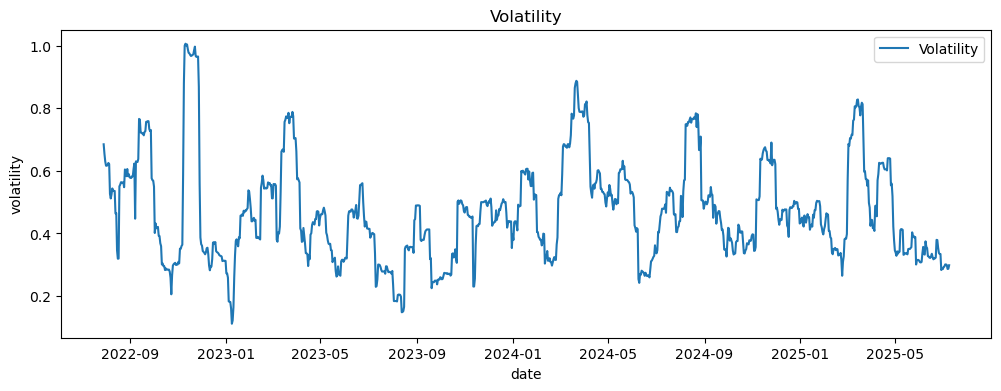

In [16]:
plt.figure(figsize=(12, 4)) 
plt.plot(df['Rolling_Volatility'], label="Volatility")
plt.title('Volatility') 
plt.xlabel("date")
plt.ylabel("volatility") 
plt.legend() 
plt.show()

In [17]:
#создание целевого признака
df['Target_Volatility_Spike'] = (df['Rolling_Volatility'].shift(-1) > volatility_threshold).astype(int)

In [18]:
df.head(3)

Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2022-07-30  23656.207031  24572.580078  23580.507812  23796.818359   
2022-07-31  23336.896484  24121.642578  23275.703125  23652.070312   
2022-08-01  23314.199219  23464.787109  22890.796875  23336.718750   

Price            Volume Log_Return Rolling_Volatility Target_Volatility_Spike  
Ticker          BTC-USD                                                        
Date                                                                           
2022-07-30  28148218301  -0.006255           0.684976                       0  
2022-07-31  23553591896  -0.013590           0.654304                       0  
2022-08-01  25849159141  -0.000973           0.629904                       0

In [19]:
print(f"Размер датафрейма после базовой подготовки: {df.shape}")
print("\nРаспределение целевой переменной:")
print(df['Target_Volatility_Spike'].value_counts(normalize=True))

Размер датафрейма после базовой подготовки: (1076, 8)

Распределение целевой переменной:
Target_Volatility_Spike
0    0.899628
1    0.100372
Name: proportion, dtype: float64


In [20]:
print("\n--- Шаг 1: Создание ценовых признаков ---")
# Лагированные логарифмические доходности
for i in [1, 2, 3, 5, 10]: # Лаги за 1, 2, 3, 5, 10 дней
    df[f'Log_Return_lag_{i}'] = df['Log_Return'].shift(i)


--- Шаг 1: Создание ценовых признаков ---


In [21]:
# Дневной диапазон относительно цены закрытия
df['Daily_Range_Ratio'] = (df['High'] - df['Low']) / df['Close']

In [22]:
# Разрывы (Gaps) - насколько цена открытия текущего дня отличается от закрытия предыдущего
df['Open_Prev_Close_Gap_Ratio'] = (df['Open'] - df['Close'].shift(1)) / df['Close'].shift(1)

In [23]:
# Относительное положение цены закрытия в дневном диапазоне
# 0 = закрытие на минимуме, 1 = закрытие на максимуме
df['Close_Position_in_Range'] = (df['Close'] - df['Low']) / (df['High'] - df['Low'])

In [24]:
# Обработка деления на ноль, если High == Low
df['Close_Position_in_Range'].fillna(0.5, inplace=True) # Можно установить 0.5 или 0, если диапазон равен 0


C:\Users\User\AppData\Local\Temp\ipykernel_3328\460677609.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close_Position_in_Range'].fillna(0.5, inplace=True) # Можно установить 0.5 или 0, если диапазон равен 0


In [25]:
# Отношение цены закрытия к открытию
df['Close_Open_Ratio'] = df['Close'] / df['Open']

In [26]:
print("Ценовые признаки созданы.")
df.dropna(inplace=True)
df.head()

Ценовые признаки созданы.


Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2022-08-09  23164.318359  23898.615234  22982.000000  23811.484375   
2022-08-10  23947.642578  24127.414062  22771.519531  23162.898438   
2022-08-11  23957.529297  24822.628906  23900.996094  23948.345703   
2022-08-12  24402.818359  24412.566406  23657.265625  23957.203125   
2022-08-13  24424.068359  24860.050781  24346.115234  24402.187500   

Price            Volume Log_Return Rolling_Volatility Target_Volatility_Spike  \
Ticker          BTC-USD                                                         
Date                                                                            
2022-08-09  23555719219  -0.027471           0.525127                       0   
2022-08-10  32837431722   0.033257           0.543867                       0   
2022-08-11  37127036580   0.000413           0.535490                       0   
2022-08-12  27265804688   0.018416           0.535793                       0   
2022-08-13  22987346289   0.000870           0.535867                       0   

Price      Log_Return_lag_1 Log_Return_lag_2 Log_Return_lag_3  \
Ticker                                                          
Date                                                            
2022-08-09         0.026972         0.009303        -0.014185   
2022-08-10        -0.027471         0.026972         0.009303   
2022-08-11         0.033257        -0.027471         0.026972   
2022-08-12         0.000413         0.033257        -0.027471   
2022-08-13         0.018416         0.000413         0.033257   

Price      Log_Return_lag_5 Log_Return_lag_10 Daily_Range_Ratio  \
Ticker                                                            
Date                                                              
2022-08-09        -0.009480         -0.006255          0.039570   
2022-08-10         0.028676         -0.013590          0.056619   
2022-08-11        -0.014185         -0.000973          0.038469   
2022-08-12         0.009303         -0.014520          0.030951   
2022-08-13         0.026972         -0.005744          0.021042   

Price      Open_Prev_Close_Gap_Ratio Close_Position_in_Range Close_Open_Ratio  
Ticker                                                                         
Date                                                                           
2022-08-09                  0.000084                0.198904         0.972821  
2022-08-10                 -0.000061                0.867415         1.033879  
2022-08-11                  0.000029                0.061340         1.000383  
2022-08-12                 -0.000014                0.987094         1.018600  
2022-08-13                 -0.000026                0.151679         1.000897

In [27]:
print("\n--- Шаг 2: Создание признаков, связанных с объёмом ---")


--- Шаг 2: Создание признаков, связанных с объёмом ---


In [28]:
# Лагированные объёмы
for i in [1, 2, 3, 5, 10]:
    df[f'Volume_lag_{i}'] = df['Volume'].shift(i)

In [29]:
# Показывает, насколько текущий объем выше/ниже среднего
volume_ma_window = 20
df['Volume_MA'] = df['Volume'].rolling(window=volume_ma_window).mean()

In [30]:
df.columns = df.columns.droplevel(1)

In [31]:
# Отношение текущего объёма к скользящему среднему объёма
df['Volume_to_MA_Ratio'] = df['Volume'] / df['Volume_MA']

In [32]:
# Изменение объёма относительно предыдущего дня
df['Volume_Daily_Change_Ratio'] = (df['Volume'] - df['Volume'].shift(1)) / df['Volume'].shift(1)

In [33]:
print("\n--- Шаг 3: Создание признаков, связанных с волатильностью ---")


--- Шаг 3: Создание признаков, связанных с волатильностью ---


In [34]:
# Лагированная скользящая волатильность
for i in [1, 2, 3, 5, 10]:
    df[f'Rolling_Volatility_lag_{i}'] = df['Rolling_Volatility'].shift(i)

In [35]:
# Изменение скользящей волатильности относительно предыдущего дня
df['Rolling_Volatility_Daily_Change_Ratio'] = (df['Rolling_Volatility'] - df['Rolling_Volatility'].shift(1)) / df['Rolling_Volatility'].shift(1)

In [36]:
# Отношение краткосрочной волатильности к долгосрочной
short_vol_window = 10
long_vol_window = 50
df['Short_Term_Volatility'] = df['Log_Return'].rolling(window=short_vol_window).std() * np.sqrt(365)
df['Long_Term_Volatility'] = df['Log_Return'].rolling(window=long_vol_window).std() * np.sqrt(365)
df['Vol_Ratio_Short_Long'] = df['Short_Term_Volatility'] / df['Long_Term_Volatility']

In [37]:
print("\n--- Шаг 4: Создание технических индикаторов ---")


--- Шаг 4: Создание технических индикаторов ---


In [38]:
# Relative Strength Index (RSI)
rsi_indicator = ta.momentum.RSIIndicator(df['Close'], window=14)
df['RSI'] = rsi_indicator.rsi()

In [39]:
# Moving Average Convergence Divergence (MACD)
macd_indicator = ta.trend.MACD(close=df[price_col], window_fast=12, window_slow=26, window_sign=9)
df['MACD'] = macd_indicator.macd()
df['MACD_Signal'] = macd_indicator.macd_signal()
df['MACD_Diff'] = macd_indicator.macd_diff() # Отклонение MACD от сигнальной линии

In [40]:
# Bollinger Bands (BB)
bb_band = ta.volatility.BollingerBands(close=df[price_col], window=20, window_dev=2)
df['BB_Upper'] = bb_band.bollinger_hband()
df['BB_Lower'] = bb_band.bollinger_lband()
df['BB_Width'] = bb_band.bollinger_wband()
df['BB_Percent'] = bb_band.bollinger_pband()

In [41]:
# Average True Range (ATR)
df['ATR'] = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=14).average_true_range()

In [42]:
df.dropna(inplace=True)

In [43]:
print("\n--- Шаг 5: Создание временных признаков ---")


--- Шаг 5: Создание временных признаков ---


In [44]:
df['Day_of_Week'] = df.index.dayofweek # 0=Понедельник, 6=Воскресенье
df['Month'] = df.index.month
df['Quarter'] = df.index.quarter
df['Year'] = df.index.year

In [45]:
feature_columns = [col for col in df.columns if col not in ['Open', 'High', 'Low', 'Close', 'Volume',
                                                            'Log_Return', 'Rolling_Volatility', 'Volume_MA',
                                                            'Short_Term_Volatility', 'Long_Term_Volatility',
                                                            'Target_Volatility_Spike']] # Исключаем целевую

In [46]:
X = df[feature_columns]
y = df['Target_Volatility_Spike']

In [47]:
X.head(3)

Price       Log_Return_lag_1  Log_Return_lag_2  Log_Return_lag_3  \
Date                                                               
2022-09-27          0.022122         -0.007150         -0.018864   
2022-09-28         -0.005850          0.022122         -0.007150   
2022-09-29          0.016409         -0.005850          0.022122   

Price       Log_Return_lag_5  Log_Return_lag_10  Daily_Range_Ratio  \
Date                                                                 
2022-09-27          0.045642           0.017794           0.074450   
2022-09-28         -0.005989          -0.035813           0.058427   
2022-09-29         -0.018864           0.006397           0.033971   

Price       Open_Prev_Close_Gap_Ratio  Close_Position_in_Range  \
Date                                                             
2022-09-27                  -0.000043                 0.136970   
2022-09-28                  -0.000310                 0.769505   
2022-09-29                   0.000054                 0.975614   

Price       Close_Open_Ratio  Volume_lag_1  ...  MACD_Diff      BB_Upper  \
Date                                        ...                            
2022-09-27          0.994210  4.414880e+10  ...  -5.836425  22022.878449   
2022-09-28          1.016860  5.857144e+10  ...  31.438056  22023.015078   
2022-09-29          1.007478  5.307130e+10  ...  66.989353  21823.526666   

Price           BB_Lower   BB_Width  BB_Percent         ATR  Day_of_Week  \
Date                                                                       
2022-09-27  17762.695574  21.415717    0.316383  848.645890            1   
2022-09-28  17772.247617  21.363183    0.389218  869.103104            2   
2022-09-29  17790.925873  20.359240    0.441929  854.518033            3   

Price       Month  Quarter  Year  
Date                              
2022-09-27      9        3  2022  
2022-09-28      9        3  2022  
2022-09-29      9        3  2022  

[3 rows x 36 columns]

In [48]:
# Let's make simple data analysis

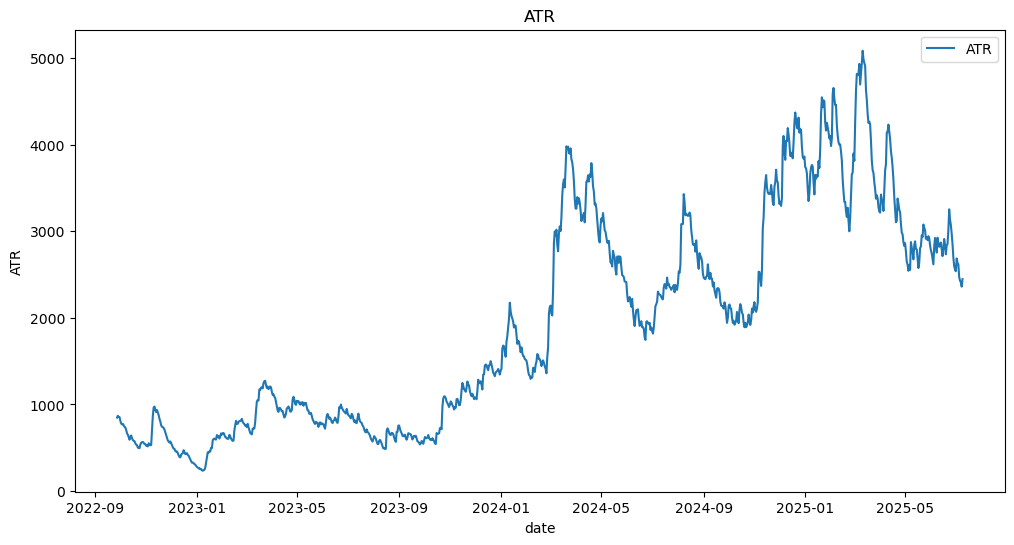

In [49]:
plt.figure(figsize=(12, 6)) 
plt.plot(df['ATR'], label="ATR")
plt.title('ATR') 
plt.xlabel("date")
plt.ylabel("ATR") 
plt.legend() 
plt.show()

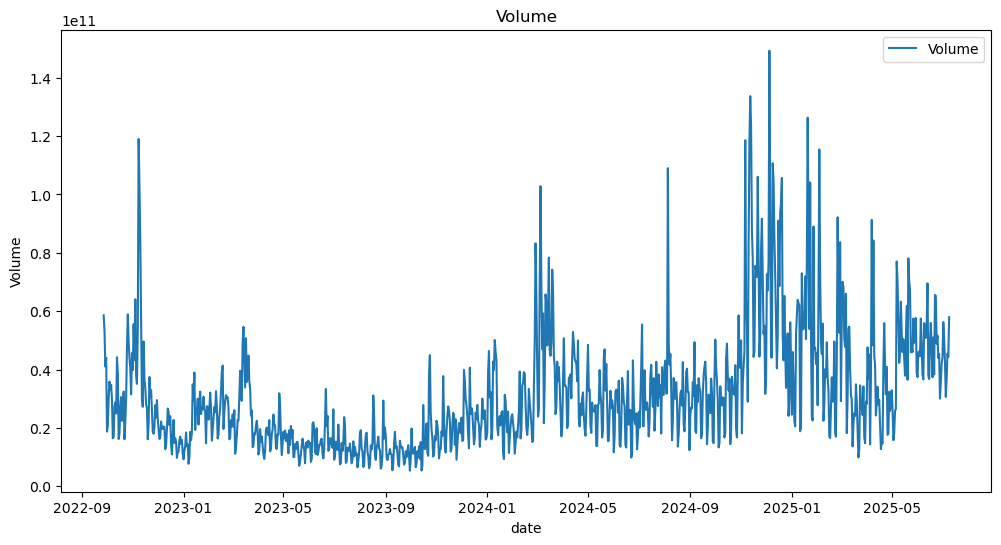

In [50]:
plt.figure(figsize=(12, 6)) 
plt.plot(df['Volume'], label="Volume")
plt.title('Volume') 
plt.xlabel("date")
plt.ylabel("Volume") 
plt.legend() 
plt.show()

In [51]:
#обучение моделей

In [52]:
# --- Параметры кросс-валидации ---
n_splits = 5 # Количество фолдов 
tscv = TimeSeriesSplit(n_splits=n_splits)

In [53]:
# --- Инициализация модели ---
model = RandomForestClassifier(n_estimators=100, random_state=42)

In [54]:
# --- Инициализация для SMOTE и Scaling ---
scaler = StandardScaler()
# sampling_strategy='auto' (по умолчанию) будет делать миноритарный класс таким же по размеру, как мажоритарный
smote = SMOTE(random_state=42, sampling_strategy='auto')

In [55]:
# --- Списки для сбора результатов ---
fold_results = []
all_y_test = []
all_y_pred = []
all_y_proba = []

In [56]:
# --- Инициализация моделей для сравнения ---
models = {
    'LogisticRegression': LogisticRegression(random_state=42, solver='liblinear', max_iter=1000), # solver='liblinear' хорош для небольших данных и L1/L2 регуляризации
    'RandomForestClassifier': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBClassifier': XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42) # use_label_encoder=False убирает ворнинг
}

In [57]:
all_models_results = {}

In [58]:
comparison_df_data = []

In [59]:
# --- Цикл по каждой модели ---
for model_name, model_instance in models.items():
    print(f"\n======== Обучение и оценка модели: {model_name} ========")
    fold_metrics = []
    
    # Списки для общей ROC-кривой и PR-кривой для текущей модели (храним как списки фолдов)
    model_all_y_test_folds = []
    model_all_y_proba_folds = []

    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        print(f"\n--- Fold {fold+1}/{n_splits} для {model_name} ---")

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # 1. Масштабирование признаков
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

        # 2. Применение SMOTE (ТОЛЬКО на обучающем наборе)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

        print(f"Размер обучающего набора после SMOTE: {len(X_train_resampled)} строк")
        print(f"Распределение классов в обучающем наборе после SMOTE:\n{y_train_resampled.value_counts(normalize=True)}")

        # 3. Обучение модели
        model_instance.fit(X_train_resampled, y_train_resampled)

        # 4. Прогнозирование
        y_pred = model_instance.predict(X_test_scaled)
        y_proba = model_instance.predict_proba(X_test_scaled)[:, 1]

        # 5. Оценка метрик
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        roc_auc = np.nan
        if len(np.unique(y_test)) == 2:
            roc_auc = roc_auc_score(y_test, y_proba)
        else:
            print(f"Внимание: Для Fold {fold+1} в тестовом наборе присутствует только один класс. ROC AUC не может быть вычислен.")

        print(f"Результаты для Fold {fold+1} ({model_name}):")
        print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")

        fold_metrics.append({'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'roc_auc': roc_auc})
        
        model_all_y_test_folds.append(y_test.tolist()) # Сохраняем y_test для этого фолда
        model_all_y_proba_folds.append(y_proba.tolist()) # Сохраняем y_proba для этого фолда

    all_models_results[model_name] = {
        'fold_metrics': fold_metrics,
        'all_y_test_folds': model_all_y_test_folds, # Список списков для каждого фолда
        'all_y_proba_folds': model_all_y_proba_folds # Список списков для каждого фолда
    }


======== Обучение и оценка модели: LogisticRegression ========

--- Fold 1/5 для LogisticRegression ---
Размер обучающего набора после SMOTE: 298 строк
Распределение классов в обучающем наборе после SMOTE:
Target_Volatility_Spike
1    0.5
0    0.5
Name: proportion, dtype: float64
Результаты для Fold 1 (LogisticRegression):
Accuracy: 0.9467, Precision: 0.6667, Recall: 0.5000, F1-Score: 0.5714, ROC AUC: 0.9708

--- Fold 2/5 для LogisticRegression ---
Размер обучающего набора после SMOTE: 612 строк
Распределение классов в обучающем наборе после SMOTE:
Target_Volatility_Spike
1    0.5
0    0.5
Name: proportion, dtype: float64
Внимание: Для Fold 2 в тестовом наборе присутствует только один класс. ROC AUC не может быть вычислен.
Результаты для Fold 2 (LogisticRegression):
Accuracy: 0.8994, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000, ROC AUC: nan

--- Fold 3/5 для LogisticRegression ---
Размер обучающего набора после SMOTE: 950 строк
Распределение классов в обучающем наборе после SM

E:\anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:13:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
E:\anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:13:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
E:\anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:13:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
E:\anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:13:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Результаты для Fold 1 (XGBClassifier):
Accuracy: 0.9822, Precision: 0.8000, Recall: 1.0000, F1-Score: 0.8889, ROC AUC: 0.9973

--- Fold 2/5 для XGBClassifier ---
Размер обучающего набора после SMOTE: 612 строк
Распределение классов в обучающем наборе после SMOTE:
Target_Volatility_Spike
1    0.5
0    0.5
Name: proportion, dtype: float64
Внимание: Для Fold 2 в тестовом наборе присутствует только один класс. ROC AUC не может быть вычислен.
Результаты для Fold 2 (XGBClassifier):
Accuracy: 1.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000, ROC AUC: nan

--- Fold 3/5 для XGBClassifier ---
Размер обучающего набора после SMOTE: 950 строк
Распределение классов в обучающем наборе после SMOTE:
Target_Volatility_Spike
1    0.5
0    0.5
Name: proportion, dtype: float64
Результаты для Fold 3 (XGBClassifier):
Accuracy: 0.9231, Precision: 0.7037, Recall: 0.7917, F1-Score: 0.7451, ROC AUC: 0.9491

--- Fold 4/5 для XGBClassifier ---
Размер обучающего набора после SMOTE: 1240 строк
Распределен

E:\anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:13:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [60]:
for model_name, results in all_models_results.items():
    fold_metrics = results['fold_metrics']
    y_test_folds = results['all_y_test_folds'] # Получаем y_test для каждого фолда

    # Фильтруем фолды, где был позитивный класс в y_test
    conditional_folds_metrics = []
    for i, fold_res in enumerate(fold_metrics):
        # Проверяем, есть ли хотя бы один позитивный класс (1) в этом y_test
        if np.sum(np.array(y_test_folds[i]) == 1) > 0:
            conditional_folds_metrics.append(fold_res)

    if conditional_folds_metrics: # Если есть хоть один подходящий фолд
        avg_accuracy = np.mean([res['accuracy'] for res in conditional_folds_metrics])
        avg_precision = np.mean([res['precision'] for res in conditional_folds_metrics])
        avg_recall = np.mean([res['recall'] for res in conditional_folds_metrics])
        avg_f1 = np.mean([res['f1'] for res in conditional_folds_metrics])
        valid_roc_aucs = [res['roc_auc'] for res in conditional_folds_metrics if not np.isnan(res['roc_auc'])]
        avg_roc_auc = np.mean(valid_roc_aucs) if valid_roc_aucs else np.nan
    else: # Если ни одного подходящего фолда не найдено
        avg_accuracy, avg_precision, avg_recall, avg_f1, avg_roc_auc = np.nan, np.nan, np.nan, np.nan, np.nan

    comparison_df_data.append({
        'Model': model_name,
        'Avg Accuracy': avg_accuracy,
        'Avg Precision': avg_precision,
        'Avg Recall': avg_recall,
        'Avg F1-Score': avg_f1,
        'Avg ROC AUC': avg_roc_auc
    })

In [61]:
final_comparison_df = pd.DataFrame(comparison_df_data)
# Сортируем по F1-Score, так как это хорошая метрика для несбалансированных классов
final_comparison_df_sorted = final_comparison_df.sort_values(by='Avg F1-Score', ascending=False)

print(final_comparison_df_sorted.to_string(index=False))

                 Model  Avg Accuracy  Avg Precision  Avg Recall  Avg F1-Score  Avg ROC AUC
         XGBClassifier      0.961538       0.793883    0.890625      0.838472     0.981685
    LogisticRegression      0.934911       0.694073    0.697917      0.687234     0.963319
RandomForestClassifier      0.946746       0.639338    0.677083      0.655258     0.977264


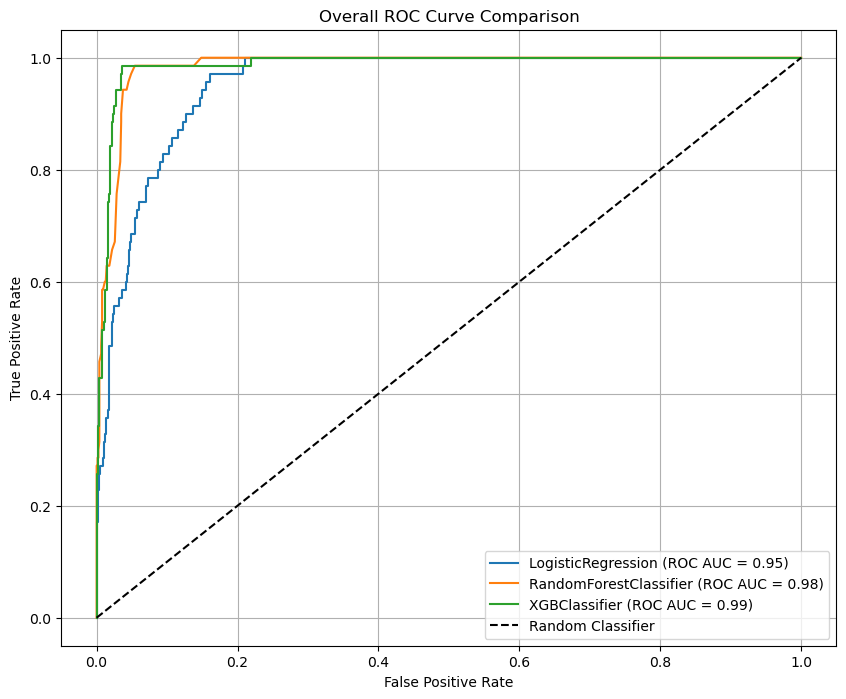

In [62]:
# --- Построение общей ROC-кривой для каждой модели ---
plt.figure(figsize=(10, 8))
for model_name, results in all_models_results.items():
    # Сплющиваем списки списков в один плоский список для построения кривых
    y_true_combined = [item for sublist in results['all_y_test_folds'] for item in sublist]
    y_proba_combined = [item for sublist in results['all_y_proba_folds'] for item in sublist]

    if len(np.unique(y_true_combined)) == 2:
        fpr, tpr, _ = roc_curve(y_true_combined, y_proba_combined)
        overall_auc = roc_auc_score(y_true_combined, y_proba_combined)
        plt.plot(fpr, tpr, label=f'{model_name} (ROC AUC = {overall_auc:.2f})')
    else:
        print(f"\nНевозможно построить ROC-кривую для {model_name}: в совокупности тестовых наборов присутствует только один класс.")

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overall ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

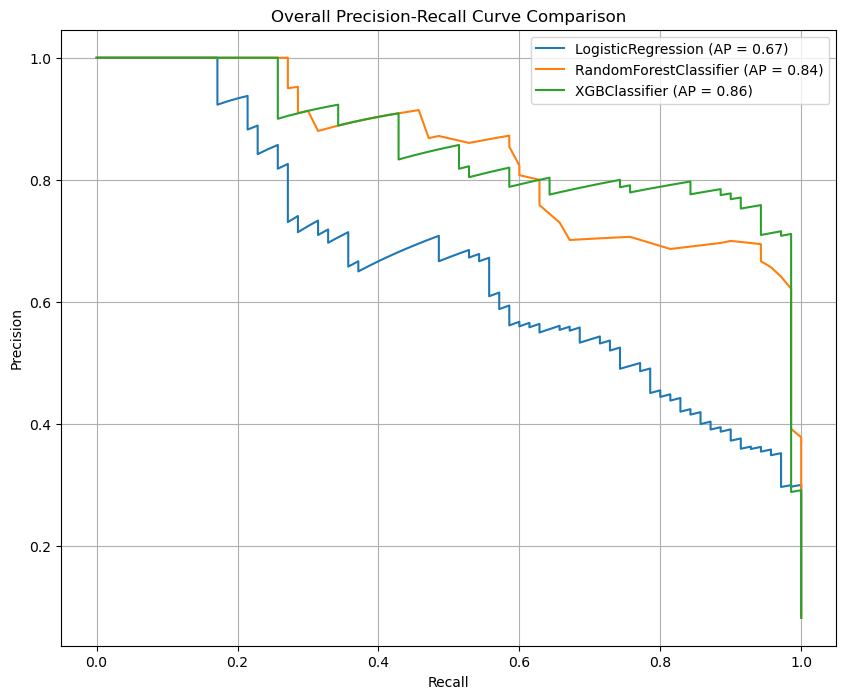

                 Model  Avg Accuracy  Avg Precision  Avg Recall  Avg F1-Score  Avg ROC AUC
         XGBClassifier      0.961538       0.793883    0.890625      0.838472     0.981685
    LogisticRegression      0.934911       0.694073    0.697917      0.687234     0.963319
RandomForestClassifier      0.946746       0.639338    0.677083      0.655258     0.977264


In [63]:
# --- Построение общей Precision-Recall кривой для каждой модели ---
plt.figure(figsize=(10, 8))
for model_name, results in all_models_results.items():
    y_true_combined = [item for sublist in results['all_y_test_folds'] for item in sublist]
    y_proba_combined = [item for sublist in results['all_y_proba_folds'] for item in sublist]

    # Precision-Recall Curve требует наличия обоих классов и хотя бы одного позитивного примера
    if len(np.unique(y_true_combined)) == 2 and np.sum(np.array(y_true_combined) == 1) > 0:
        precision_curve, recall_curve, _ = precision_recall_curve(y_true_combined, y_proba_combined)
        from sklearn.metrics import average_precision_score
        avg_precision_score = average_precision_score(y_true_combined, y_proba_combined)
        plt.plot(recall_curve, precision_curve, label=f'{model_name} (AP = {avg_precision_score:.2f})')
    else:
        print(f"\nНевозможно построить PR-кривую для {model_name}: в совокупности тестовых наборов отсутствует позитивный класс.")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Overall Precision-Recall Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()
print(final_comparison_df_sorted.to_string(index=False)) #в этой части кода дважды выводится значения метрик моделей

In [64]:
best_model_name = final_comparison_df_sorted.iloc[0]['Model']
print(f"\n--- Confusion Matrix для лучшей модели: {best_model_name} ---")


--- Confusion Matrix для лучшей модели: XGBClassifier ---


In [65]:
# Собираем все y_true и y_proba для лучшей модели
y_true_best_combined = [item for sublist in all_models_results[best_model_name]['all_y_test_folds'] for item in sublist]
y_proba_best_combined = [item for sublist in all_models_results[best_model_name]['all_y_proba_folds'] for item in sublist]
y_pred_best_combined = (np.array(y_proba_best_combined) > 0.5).astype(int) # Используем порог 0.5


In [66]:
cm = confusion_matrix(y_true_best_combined, y_pred_best_combined)

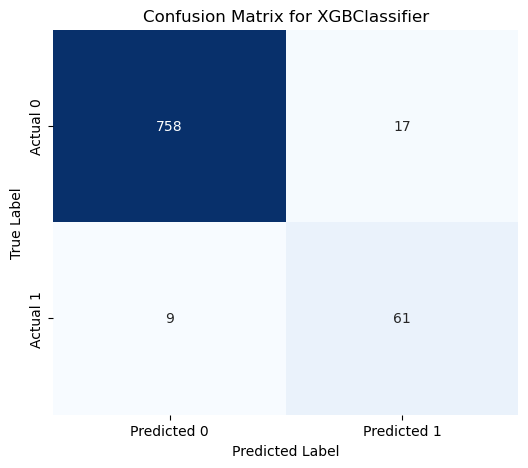

In [67]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()

In [68]:
best_model_name = final_comparison_df_sorted.iloc[0]['Model']
print(f"\nДемонстрация работы лучшей модели: {best_model_name}")


Демонстрация работы лучшей модели: XGBClassifier


In [69]:
# Получим индексы для всех тестовых фолдов
all_test_indices = []
for train_idx, test_idx in tscv.split(X): # tscv был определен ранее
    all_test_indices.extend(X.iloc[test_idx].index.tolist())
# Убедимся, что индексы уникальны и отсортированы, если они могут повторяться
unique_sorted_test_indices = sorted(list(set(all_test_indices)))    

In [70]:
# Сплющиваем y_true и y_proba для лучшей модели
y_true_best_combined = [item for sublist in all_models_results[best_model_name]['all_y_test_folds'] for item in sublist]
y_proba_best_combined = [item for sublist in all_models_results[best_model_name]['all_y_proba_folds'] for item in sublist]

In [71]:
# Создаем Series с правильными индексами
# Важно: количество элементов в y_true_best_combined должно соответствовать unique_sorted_test_indices
# Это выполняется, если мы правильно собрали индексы и предсказания
if len(y_true_best_combined) == len(unique_sorted_test_indices):
    y_true_series = pd.Series(y_true_best_combined, index=unique_sorted_test_indices)
    y_proba_series = pd.Series(y_proba_best_combined, index=unique_sorted_test_indices)
else:
    print("Внимание: Количество предсказаний не совпадает с количеством уникальных тестовых индексов. Возможно, данные были обрезаны или есть другие несоответствия.")
    # Если это происходит, вам нужно будет внимательнее отследить, как формируются y_true_best_combined и unique_sorted_test_indices.
    # Для демонстрации, можем использовать более простой, но менее надежный способ:
    y_true_series = pd.Series(y_true_best_combined) # Без индекса или с дефолтным
    y_proba_series = pd.Series(y_proba_best_combined)

NameError: name 'prediction_threshold' is not defined

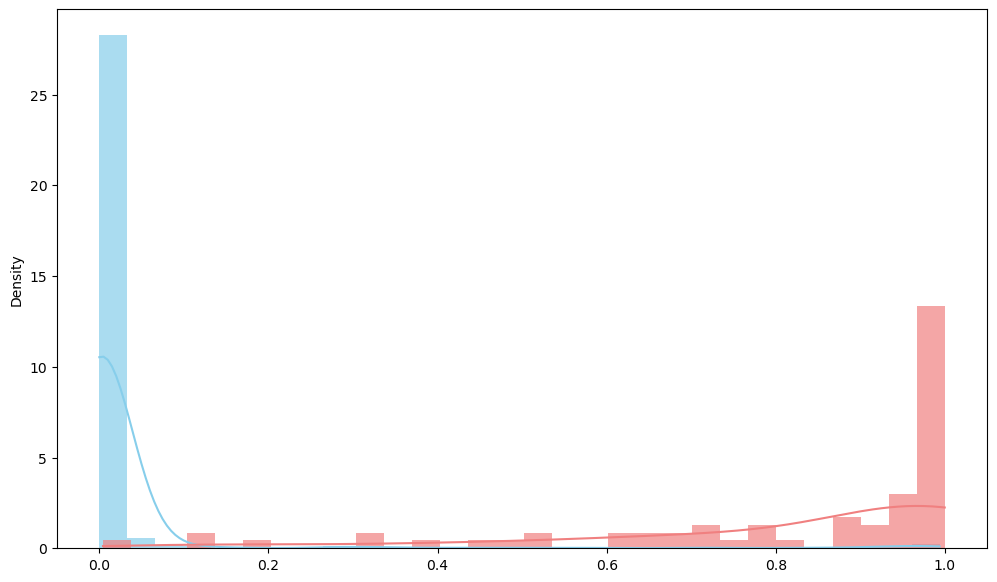

In [72]:
# --- 2. График: Распределение предсказанных вероятностей ---

plt.figure(figsize=(12, 7)) # Увеличиваем размер для лучшей читаемости
sns.histplot(y_proba_series[y_true_series == 0], color='skyblue', label='Вероятности для класса 0 (Нет всплеска)',
             kde=True, stat="density", linewidth=0, alpha=0.7, bins=30) # Увеличил количество бинов для детализации
sns.histplot(y_proba_series[y_true_series == 1], color='lightcoral', label='Вероятности для класса 1 (Всплеск)',
             kde=True, stat="density", linewidth=0, alpha=0.7, bins=30) # Увеличил количество бинов для детализации
plt.axvline(prediction_threshold, color='green', linestyle='--', linewidth=2, label=f'Порог классификации ({prediction_threshold})')
plt.title(f'Распределение предсказанных вероятностей для {best_model_name}', fontsize=16)
plt.xlabel('Предсказанная вероятность всплеска', fontsize=12)
plt.ylabel('Плотность', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
# --- 3. Если хотите, можно наложить предсказания на график волатильности (требует данных) ---
# Для этого нужен доступ к df с колонкой Rolling_Volatility и индексом
if 'Rolling_Volatility' in df.columns:
    plt.figure(figsize=(18, 8))

    # График общей волатильности
    plt.plot(df.index, df['Rolling_Volatility'], color='grey', alpha=0.7, label='Скользящая волатильность')

    # Отмечаем истинные всплески волатильности
    true_spikes_df = df[df['Target_Volatility_Spike'] == 1]
    if not true_spikes_df.empty:
        plt.plot(true_spikes_df.index, df.loc[true_spikes_df.index, 'Rolling_Volatility'], 'o', color='blue', markersize=6, label='Истинный всплеск (Цель = 1)', alpha=0.8)

    # Отмечаем предсказанные всплески волатильности на основе y_pred_series
    predicted_spikes_df = df.loc[y_pred_series[y_pred_series == 1].index]
    if not predicted_spikes_df.empty:
        plt.plot(predicted_spikes_df.index, df.loc[predicted_spikes_df.index, 'Rolling_Volatility'], 'x', color='red', markersize=7, label='Предсказанный всплеск (Модель = 1)', alpha=0.8)

    plt.title(f'Волатильность с истинными и предсказанными всплесками для {best_model_name}')
    plt.xlabel('Дата')
    plt.ylabel('Скользящая волатильность')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

else:
    print("Колонка 'Rolling_Volatility' не найдена в DataFrame для построения дополнительного графика.")

In [ ]:
prediction_threshold = 0.5
y_pred_series = (y_proba_series > prediction_threshold).astype(int)

In [ ]:
# --- Подготовка данных для графиков ценности ---
# Нам нужны логарифмические доходности для тестового периода, соответствующие предсказаниям
# Убедитесь, что df содержит 'Log_Return' и имеет индекс типа DatetimeIndex
if 'Log_Return' not in df.columns:
    print("Ошибка: Колонка 'Log_Return' не найдена в вашем DataFrame. Невозможно построить графики ценности.")
else:
    # Создаем DataFrame для анализа стратегии, объединяя предсказания и реальные доходности
    # Берем только те строки из df, которые были в тестовых фолдах (т.е. имеют предсказания)
    strategy_df = pd.DataFrame({
        'Log_Return': df['Log_Return'].loc[y_true_series.index], # Берем доходности только для тестовых периодов
        'Predicted_Spike': y_pred_series,
        'True_Spike': y_true_series
    })
    strategy_df.dropna(inplace=True) # Удалим возможные NaN, если индексы не идеально совпали

    # --- 1. График: Распределение доходностей в зависимости от предсказаний модели ---
    plt.figure(figsize=(12, 7))
    sns.histplot(strategy_df[strategy_df['Predicted_Spike'] == 0]['Log_Return'],
                 color='green', label='Предсказано: Нет всплеска (0)', kde=True, stat="density", bins=50)
    sns.histplot(strategy_df[strategy_df['Predicted_Spike'] == 1]['Log_Return'],
                 color='purple', label='Предсказано: Всплеск (1)', kde=True, stat="density", bins=50, alpha=0.6)
    
    plt.title(f'Распределение доходностей (Log_Return) по предсказаниям модели {best_model_name}', fontsize=16)
    plt.xlabel('Логарифмическая доходность', fontsize=12)
    plt.ylabel('Плотность', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [ ]:
# Пример стратегии: "Покупаем, если модель предсказывает спокойствие (Predicted_Spike == 0)"
strategy_returns_no_spike = strategy_df[strategy_df['Predicted_Spike'] == 0]['Log_Return']
cumulative_strategy_no_spike = np.exp(strategy_returns_no_spike.cumsum()) - 1 # Преобразуем лог. доходности в кумулятивные

    # Пример стратегии: "Покупаем, если модель предсказывает всплеск (Predicted_Spike == 1)"
strategy_returns_spike = strategy_df[strategy_df['Predicted_Spike'] == 1]['Log_Return']
cumulative_strategy_spike = np.exp(strategy_returns_spike.cumsum()) - 1

    # Кумулятивная доходность "Buy and Hold" (для сравнения)
    # Берем доходности только для тестового периода, чтобы соответствовать стратегии
buy_and_hold_returns = strategy_df['Log_Return']
cumulative_buy_and_hold = np.exp(buy_and_hold_returns.cumsum()) - 1


plt.figure(figsize=(18, 8))
    
    # Чтобы графики начинались с 0, добавим начальную точку
start_value = 0.0 # Кумулятивная доходность начинается с 0%
    
    # Добавим начальные точки для каждой стратегии
plot_data_no_spike = pd.concat([pd.Series([start_value], index=[cumulative_strategy_no_spike.index.min() - pd.Timedelta(days=1)]), cumulative_strategy_no_spike])
plot_data_spike = pd.concat([pd.Series([start_value], index=[cumulative_strategy_spike.index.min() - pd.Timedelta(days=1)]), cumulative_strategy_spike])
plot_data_buy_hold = pd.concat([pd.Series([start_value], index=[cumulative_buy_and_hold.index.min() - pd.Timedelta(days=1)]), cumulative_buy_and_hold])


plt.plot(plot_data_buy_hold.index, plot_data_buy_hold * 100, label='Базовая стратегия (Купи и держи)', color='blue', linewidth=2)
plt.plot(plot_data_no_spike.index, plot_data_no_spike * 100, label='Стратегия: Покупка при предсказании "Нет всплеска" (0)', color='green', linewidth=2)
plt.plot(plot_data_spike.index, plot_data_spike * 100, label='Стратегия: Покупка при предсказании "Всплеск" (1)', color='purple', linewidth=2, linestyle='--')


plt.title(f'Кумулятивная доходность стратегий на основе предсказаний {best_model_name}', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Кумулятивная доходность (%)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
# Доходности для стратегии шорта: если модель предсказала всплеск (Predicted_Spike == 1),
    # мы берем ОТРИЦАТЕЛЬНУЮ логарифмическую доходность, иначе - 0 (мы вне рынка).
short_strategy_returns = strategy_df.apply(
    lambda row: -row['Log_Return'] if row['Predicted_Spike'] == 1 else 0, axis=1
    )
    
    # Кумулятивная доходность стратегии шорта
cumulative_short_strategy = np.exp(short_strategy_returns.cumsum()) - 1

    # Кумулятивная доходность "Buy and Hold" (для сравнения)
    # Берем доходности только для тестового периода, чтобы соответствовать стратегии
buy_and_hold_returns = strategy_df['Log_Return']
cumulative_buy_and_hold = np.exp(buy_and_hold_returns.cumsum()) - 1

plt.figure(figsize=(18, 8))

    # Чтобы графики начинались с 0, добавим начальную точку
start_value = 0.0 # Кумулятивная доходность начинается с 0%
    
    # Определим минимальную дату для начальной точки
min_date = min(cumulative_short_strategy.index.min(), cumulative_buy_and_hold.index.min()) - pd.Timedelta(days=1)

    # Добавим начальные точки для каждой стратегии
plot_data_short = pd.concat([pd.Series([start_value], index=[min_date]), cumulative_short_strategy])
plot_data_buy_hold = pd.concat([pd.Series([start_value], index=[min_date]), cumulative_buy_and_hold])

plt.plot(plot_data_buy_hold.index, plot_data_buy_hold * 100, label='Базовая стратегия (Купи и держи)', color='blue', linewidth=2)
plt.plot(plot_data_short.index, plot_data_short * 100, label='Стратегия: Продажа (Шорт) при предсказании "Всплеск" (1)', color='red', linewidth=2)

plt.title(f'Кумулятивная доходность стратегии "Продажа при всплеске" для {best_model_name}', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Кумулятивная доходность (%)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
xgboost_model_name = 'XGBClassifier'
if xgboost_model_name not in models:
    print(f"Ошибка: Модель '{xgboost_model_name}' не была включена в список моделей для обучения.")
else:
    # 2. Переобучим XGBoost на одном полном наборе данных (для получения финальной важности признаков)
    # Это упрощенный подход для демонстрации. В продакшене лучше усреднять по фолдам.
    print(f"\nПереобучение {xgboost_model_name} на полном тестовом наборе для демонстрации важности признаков...")

    # Для получения "финальной" важности признаков, возьмём последний тренировочный набор из TimeSeriesSplit
    # Это будет самый большой и последний по времени тренировочный набор.
    # Это не идеально, но достаточно для демонстрации.
    train_indices, _ = list(tscv.split(X))[-1]
    X_train_final, y_train_final = X.iloc[train_indices], y.iloc[train_indices]

    # Применяем масштабирование и SMOTE к этому финальному набору
    scaler_final = StandardScaler()
    X_train_final_scaled = scaler_final.fit_transform(X_train_final)
    X_train_final_scaled = pd.DataFrame(X_train_final_scaled, columns=X_train_final.columns, index=X_train_final.index)
    
    smote_final = SMOTE(random_state=42, sampling_strategy='auto')
    X_train_resampled_final, y_train_resampled_final = smote_final.fit_resample(X_train_final_scaled, y_train_final)

    # Инициализируем и обучаем новый экземпляр XGBoost
    final_xgboost_model = models[xgboost_model_name] # Берем параметры, которые были определены
    final_xgboost_model.fit(X_train_resampled_final, y_train_resampled_final)

    # 3. Извлекаем важность признаков
    # 'gain' - это обычно хорошая метрика для понимания вклада признака
    feature_importances = final_xgboost_model.get_booster().get_score(importance_type='gain')

    # Преобразуем в DataFrame для удобства сортировки и визуализации
    feature_importance_df = pd.DataFrame({
        'Feature': list(feature_importances.keys()),
        'Importance': list(feature_importances.values())
    })

# Сортируем по важности
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # --- Построение графика важности признаков ---
    plt.figure(figsize=(12, max(8, len(feature_importance_df) * 0.4))) # Динамический размер графика
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title(f'Важность признаков для {xgboost_model_name} (по Gain)', fontsize=16)
    plt.xlabel('Важность (Gain)', fontsize=12)
    plt.ylabel('Признак', fontsize=12)
    plt.tight_layout()
    plt.show()

    print("\nТоп-10 самых важных признаков:")
    print(feature_importance_df.head(10).to_string(index=False))